<a href="https://colab.research.google.com/github/Gkdas2k1/Federated-Image-Reconstruction/blob/main/Working_Model_For_Federated_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow matplotlib numpy pillow scikit-image --quiet

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from skimage.metrics import peak_signal_noise_ratio as psnr
from PIL import Image
import io
from google.colab import files
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Configurable parameters
IMAGE_SIZE = 32  # Increased resolution for better detail
BATCH_SIZE = 16   # Reduced for CPU stability
EPOCHS = 15       # Increased for convergence

def create_autoencoder():
    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    # Encoder with residual blocks
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder with skip connections
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(encoded)
    x = layers.BatchNormalization()(x)
    x = layers.Concatenate()([x, layers.UpSampling2D()(layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs))])
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

In [ ]:
def train_autoencoder():
    # Load CIFAR-10 dataset (use larger resolution)
    (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

    # Resize to 64x64
    x_train = tf.image.resize(x_train.astype('float32') / 255.0, [IMAGE_SIZE, IMAGE_SIZE]).numpy()
    x_test = tf.image.resize(x_test.astype('float32') / 255.0, [IMAGE_SIZE, IMAGE_SIZE]).numpy()

    # Create datasets with noise injection
    def add_noise(image):
        noise_factor = 0.15  # Increased noise for robustness
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise_factor)
        return tf.clip_by_value(image + noise, 0.0, 1.0), image

    train_ds = (
        tf.data.Dataset.from_tensor_slices(x_train)
        .map(add_noise, num_parallel_calls=tf.data.AUTOTUNE)
        .shuffle(10000)
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
    )

    test_ds = (
        tf.data.Dataset.from_tensor_slices(x_test)
        .map(add_noise, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
    )

    # Build and compile model
    autoencoder = create_autoencoder()
    checkpoint = ModelCheckpoint(
        'best_denoiser.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min'
    )
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)

    # Train model
    history = autoencoder.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=test_ds,
        callbacks=[checkpoint, reduce_lr],
        verbose=1
    )

    return autoencoder

In [ ]:
def load_or_train_model():
    if os.path.exists('best_denoiser.h5'):
        print("✅ Loading pre-trained model...")
        # Explicitly specify the 'mse' loss function during loading
        return tf.keras.models.load_model('best_denoiser.h5', custom_objects={'mse': tf.keras.losses.MeanSquaredError()})
    else:
        print("⚠️ No saved model found. Training new model...")
        return train_autoencoder()

In [ ]:
def add_gaussian_noise(image, sigma=30):  # Increased noise level
    return np.clip(image + np.random.normal(0, sigma, image.shape), 0, 255).astype(np.uint8)

def add_dp_noise(image, epsilon=0.5, delta=1e-5):  # Reduced epsilon for less noise
    sensitivity = 255 * np.sqrt(3)
    sigma = sensitivity * np.sqrt(2 * np.log(1.25 / delta)) / epsilon
    noise = np.random.normal(0, sigma, image.shape)
    return np.clip(image + noise, 0, 255).astype(np.uint8)

In [ ]:
def upload_image():
    uploaded = files.upload()
    img_path = next(iter(uploaded))
    img = Image.open(io.BytesIO(uploaded[img_path])).convert("RGB")
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.BICUBIC)
    return np.array(img)

In [ ]:
def prepare_input(img):
    return tf.expand_dims(img.astype('float32') / 255., axis=0)

def reconstruct(noisy_img):
    processed = prepare_input(noisy_img)
    reconstructed = autoencoder.predict(processed)[0]
    return (reconstructed * 255).clip(0, 255).astype(np.uint8)

In [ ]:
# Main execution flow
autoencoder = load_or_train_model()

original = upload_image()
noisy = add_gaussian_noise(original)
denoised = cv2.GaussianBlur(noisy, (5,5), 1.0)
dp_version = add_dp_noise(original)

reconstructions = {
    "Noisy Input": noisy,
    "Denoised (Gaussian Blur)": denoised,
    "DP Version Input": dp_version,
    "Reconstructed (Noisy)": reconstruct(noisy),
    "Reconstructed (DP)": reconstruct(dp_version)
}

✅ Loading pre-trained model...


Saving download.jpg to download (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


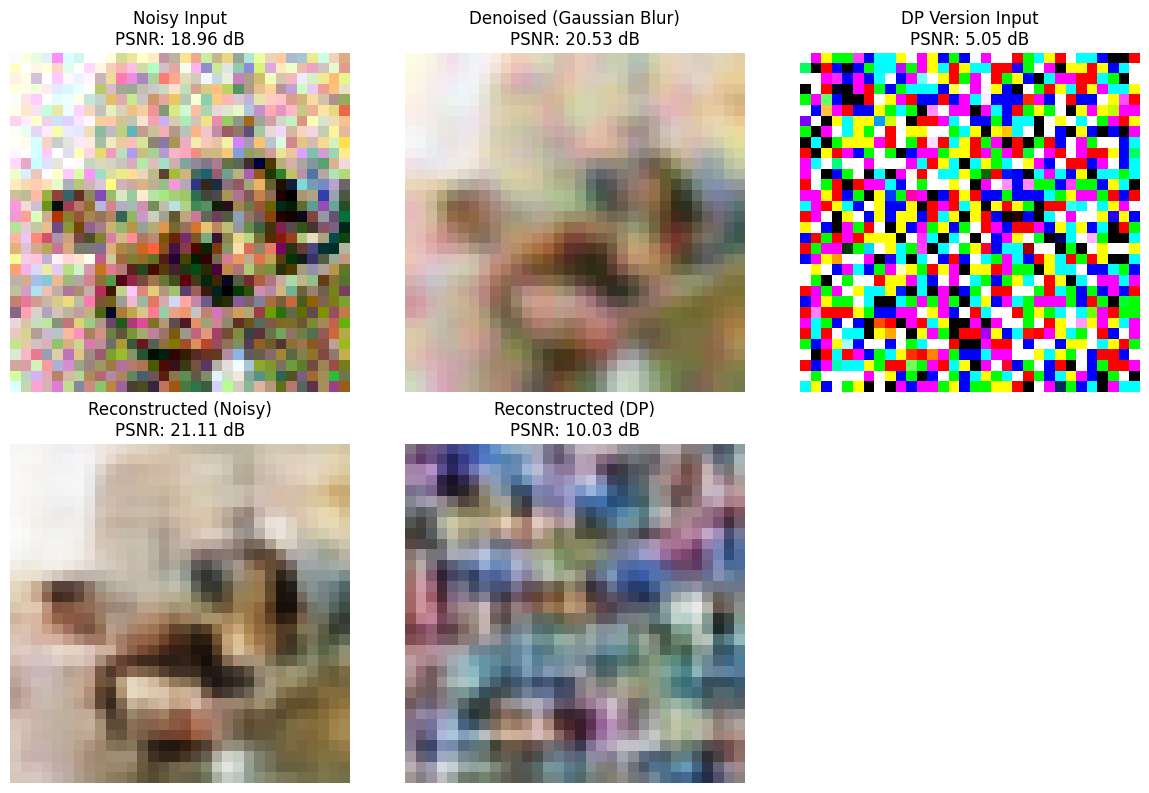

In [ ]:
# Visualization
plt.figure(figsize=(12, 8))
for i, (title, img) in enumerate(reconstructions.items()):
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"{title}\nPSNR: {psnr(original, img):.2f} dB")
    plt.axis('off')

plt.tight_layout()
plt.show()